In [17]:
import re
import random
import pandas as pd
import hashlib

In [18]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)



cards_to_age['head'] = cards_to_age['head'].str.strip()

# remove headers I don't want anymore
undesired_headers = ['CCH Axcess']
cards_to_age = cards_to_age.loc[~cards_to_age['head'].isin(undesired_headers), :].copy()

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.5) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.3) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.075

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())
cards_to_age['head_count'] = cards_to_age.groupby('head')['head'].transform("count")


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [19]:
ave_order = ('age', 'mean')
sum_order = ('age', 'sum')

stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(ave_order)
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Node.JS and React,406.392407,13.109432,21.018870,31
"Mexican Gothic, Moreno-Garcia",793.217326,28.329190,48.283220,28
Azure Functions Core Tools,583.509178,34.324069,47.943740,17
C# Basics,45.322122,45.322122,45.322122,1
Node.js and Vite,2095.837276,51.117982,80.986617,41
Django,2070.994218,51.774855,73.883441,40
Python,4684.875139,60.062502,179.627700,78
Azure Files Documentation,3897.393995,64.956567,158.311373,60
Active Directory and Azure Files,2640.748307,71.371576,111.976805,37
CCH Tax Forms Project,1542.147059,73.435574,148.213466,21


# Histogram

sum of ages: ~53053.63


<Axes: >

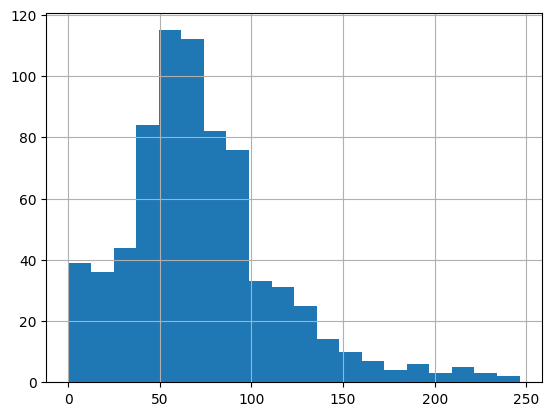

In [20]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~53053.63


<Axes: >

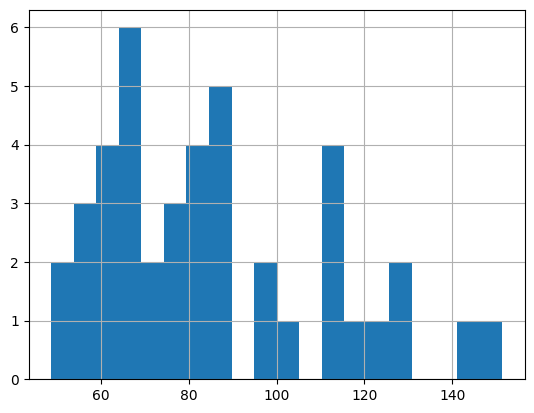

In [21]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='Terraform Codebox']['age'].hist(bins=20)

# Completely Random Shuffle

In [22]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [23]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# N-fold shuffle


## Age Sum

In [24]:
# n = 3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [25]:
n=3
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
remake_card_document(existing_cards=existing_cards)

existing_cards.head(10)

Cards found: 731
Total card age: 53053.63


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold
1,Azure VM + Developer,Dotfiles\nA collection of personal configurati...,bc791352f938ed873353ee48a848a43e,-181.525765,-108.373287,181.525765,866.986296,0.765841,8,0,0
4,Azure VM + Developer,Linter\nA code analysis tool that detects erro...,701555d6da9b6657e7601179a0dd9015,-103.782288,-108.373287,181.525765,866.986296,0.765841,8,3,0
117,Azure VM + Developer,Dependency Management\nThe process of tracking...,774acfd871be251904fda0a918338ef6,-84.967885,-108.373287,181.525765,866.986296,0.765841,8,6,0
26,Azure Compute Gallery,"Managed Image – A single, region-bound image s...",4099811ce9ab63014bfbe9d3999b3e32,-224.284303,-106.202293,224.284303,1911.641271,0.128690,18,0,0
28,Azure Compute Gallery,Image Definition – A logical representation of...,0e7eb0ef0df196b643eb5e2c354e03ec,-151.992574,-106.202293,224.284303,1911.641271,0.128690,18,3,0
140,Azure Compute Gallery,Region Availability – Not all Azure regions su...,7e4c5983195ce313abde78d424c837b7,-122.411965,-106.202293,224.284303,1911.641271,0.128690,18,6,0
143,Azure Compute Gallery,"License Considerations – Some images (e.g., RH...",ccf6b6e0ae933af8482b12d5ea19c137,-77.076765,-106.202293,224.284303,1911.641271,0.128690,18,9,0
248,Azure Compute Gallery,VHD\tVirtual Hard Disk\nVM\tVirtual Machine\nI...,2c5fe1af3274328febf12eaa5e667402,-68.603972,-106.202293,224.284303,1911.641271,0.128690,18,12,0
342,Azure Compute Gallery,Image Version Deletion – Permanent action that...,9619dbf6f85c13e45c3e69b37eac129a,-56.646758,-106.202293,224.284303,1911.641271,0.128690,18,15,0
46,Vocab,Anacoluthon\nnoun\nSPA: an-uh-koh-LOO-thon\nIP...,58fe2f5c535300af7c826eb1cff7d208,-223.067111,-100.121562,223.067111,2503.039051,0.997120,25,0,0


## Age Max

In [26]:
# n = 5
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [27]:
# n=5
# # existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
#     existing_cards['subject_highest_age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_count', 'subject_highest_age', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [28]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [29]:
existing_cards.head(10)['age'].sum()

np.float64(-1294.3593866785334)

In [30]:
asc = existing_cards.age.sum() < 0

existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold
71,Power BI,Why can’t you reference a newly added column a...,a550364578e3469f2990bdec6904efc0,-246.240666,-96.062883,246.240666,3074.012270,0.980381,32,0,0
51,PnP PowerShell,Environment Variables\nVariables that are set ...,e888c7c4c00e3b122457c3d900fd4e77,-238.112257,-97.651534,238.112257,2636.591424,0.888127,27,0,0
101,JavaScript Concepts,Generate distinct arrays with fill() + map()\n...,1c477652c74da3a626b132108ec4229f,-225.802852,-96.689788,225.802852,4834.489397,0.164658,50,0,0
26,Azure Compute Gallery,"Managed Image – A single, region-bound image s...",4099811ce9ab63014bfbe9d3999b3e32,-224.284303,-106.202293,224.284303,1911.641271,0.128690,18,0,0
46,Vocab,Anacoluthon\nnoun\nSPA: an-uh-koh-LOO-thon\nIP...,58fe2f5c535300af7c826eb1cff7d208,-223.067111,-100.121562,223.067111,2503.039051,0.997120,25,0,0
52,PnP PowerShell,REST API Endpoints\nSpecific URLs used to acce...,b12f5012328f32a6c689485970705806,-221.076687,-97.651534,238.112257,2636.591424,0.888127,27,1,1
27,Azure Compute Gallery,Subscription Quotas – Limits on the number of ...,ccb8c05118173479053ff181ddffe698,-217.727981,-106.202293,224.284303,1911.641271,0.128690,18,1,1
97,Microsoft Purview,Define what each label can do. Configure the p...,2314da7a2bfdaa36bc1e3f2e5633935f,-216.133146,-85.427738,216.133146,5125.664262,0.864498,60,0,0
102,JavaScript Concepts,Express.js: A minimalist web framework for Nod...,425c10164d26897fdad3f9d7c2c6f523,-213.929938,-96.689788,225.802852,4834.489397,0.164658,50,1,1
96,Microsoft Purview,"When you create your DLP policies, you should ...",8ec1edc0f421bb7de2884cb3c7089b3e,-213.719360,-85.427738,216.133146,5125.664262,0.864498,60,1,1


In [31]:
f"Average age: {abs(existing_cards['age'].mean()):.3f}"

'Average age: 72.577'